In [1]:
import numpy as np
import pandas as pd
import json
from PIL import Image, ImageOps
from tqdm import tqdm

In [2]:
def load_json(jfile):
    with open(jfile, 'rb') as f:
        return json.load(f)

In [3]:
PATH = '/media/nas/BasesDeDonnees/retail_product_checkout/'

images_test = PATH+'test2019'
images_train = PATH+'train2019'
images_val = PATH+'val2019'

test = PATH+'instances_test2019.json'
train = PATH+'instances_train2019.json'
val = PATH+'instances_val2019.json'

test_data = load_json(test)
train_data = load_json(train)
val_data = load_json(val)

In [4]:
import os

paths = ['images',
         'images/train',
         'images/valid',
         'images/test',
         'labels',
         'labels/train',
         'labels/valid',
         'labels/test',
         'supports']

for path in paths:
    if not os.path.exists(path):
        os.mkdir(path)

In [5]:
def resize_with_padding(img, expected_size, colors=(114,114,114)):
    width, height = img.size
    ratio = width / height
    if width < height:
        img = img.resize((int(ratio*expected_size[0]),int(expected_size[0])))
    else:
        img = img.resize((int(expected_size[1]),int((1/ratio)*expected_size[1])))
        
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding, colors)

In [6]:
def resize_label_with_padding(old_size, expected_size, bbox):
    (x,y,w,h) = bbox

    ratio = old_size[0] / old_size[1]
    if old_size[0] < old_size[1]:
        new = (int(ratio*expected_size[0]),int(expected_size[0]))
    else:
        new = (int(expected_size[1]),int((1/ratio)*expected_size[1]))

    delta_width = expected_size[0] - new[0]
    delta_height = expected_size[1] - new[1]

    pad_width = delta_width // 2
    pad_height = delta_height // 2

    x_t = (pad_width +  (x)*new[0]) / expected_size[0]
    y_t = (pad_height + (y)*new[1]) / expected_size[1]
    w_t = w*new[0] / expected_size[0]
    h_t = h*new[1] / expected_size[1]
    
    return x_t,y_t,w_t,h_t
    

# PROCESSING LABEL

In [7]:
images_df = pd.DataFrame(train_data['images'])
anns_df = pd.DataFrame(train_data['annotations'])
category = pd.DataFrame(train_data['categories'])

all = pd.merge(anns_df, images_df, left_on='image_id', right_on='id')

def main():
    for i in tqdm(range(len(category))):
        id_list = (all.loc[anns_df['category_id'] == i+1])#prend tout les image de la catégorie X
        id_list = id_list[id_list['file_name'].str.contains("camera1-30.jpg")] # ( une face ,une back * 3 direction)

        for index, row in id_list.iterrows():
            xmin, ymin, width, height = row['bbox']
            image = Image.open(images_train+'/'+row['file_name'])
            #Crop for Label
            image = image.crop((int(xmin), int(ymin), int(xmin+width), int(ymin+height)))
            #Padding for (x,x)
            img = resize_with_padding(image, (160,160), (0,0,0)) 
            #Save image
            if not os.path.exists('supports/'+str(i)):
                os.mkdir('supports/'+str(i))    
            img.save('supports/'+str(i)+'/0.png')
main() # déja fait avec PhotoRoom

100%|██████████| 200/200 [00:19<00:00, 10.50it/s]


# PROCESSING IMAGE

In [8]:
category = pd.DataFrame(test_data['categories'])

images_df1 = pd.DataFrame(test_data['images'])
anns_df1 = pd.DataFrame(test_data['annotations'])

images_df2 = pd.DataFrame(val_data['images'])
anns_df2 = pd.DataFrame(val_data['annotations'])

images_df = pd.concat([images_df1, images_df2])
anns_df = pd.concat([anns_df1,anns_df2])

nb_category = len(category)

In [9]:
all = pd.merge(anns_df, images_df, left_on='image_id', right_on='id')
all = all.sort_values(by=['category_id'])
all.shape

(367935, 13)

In [10]:
all['category_id'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [11]:
# plt.figure(figsize=(8,35))
# result = pd.merge(all, category, how="outer", left_on='category_id', right_on='id')
# result['name'].value_counts().plot.barh()

In [12]:
# test_merge = pd.merge(all, category, how="outer", left_on='category_id', right_on='id')
# result['supercategory'].value_counts().sort_index().plot.barh()

In [13]:
# Create classes
#classes = np.arange(200)
#np.random.shuffle(classes)

# Or export classes
classes = np.array([192,13,55,48,141,85,36,195,150,187,6,97,148,183,135,89,198,74
,42,197,95,62,10,43,188,189,30,59,171,76,193,28,100,58,143,91
,67,79,26,32,146,176,70,96,75,144,133,190,145,18,164,104,7,1
,165,138,181,178,33,158,114,105,21,186,3,174,159,41,69,117,110,185
,12,175,82,54,24,92,72,119,157,77,194,128,122,121,113,180,87,52
,103,20,152,71,4,136,125,151,80,172,170,156,63,154,45,0,160,35
,112,46,90,107,109,51,14,106,37,83,168,101,5,81,53,22,9,137
,163,177,124,31,179,19,116,134,27,57,126,78,118,15,120,167,142,196
,147,131,23,86,68,38,184,166,65,39,139,84,34,127,47,140,199,94
,66,108,173,44,191,182,130,64,40,11,73,123,149,129,161,155,99,61
,93,169,50,153,8,162,132,16,2,115,88,56,98,25,49,102,111,17
,60,29])
classes += 1 # aucune classes 0, la première est 1 ^^ ( remove after)

print(classes.shape)

(200,)


In [14]:
print(classes[:160].shape)
print(classes[160:].shape)

(160,)
(40,)


In [15]:
TrainValid = all.loc[all['category_id'].isin(classes[:160])]
Test = all.loc[all['category_id'].isin(classes[160:])]
print(TrainValid.shape, Test.shape)

(295431, 13) (72504, 13)


In [16]:
print(all['category_id'].unique().shape)

(200,)


In [17]:
print(TrainValid['category_id'].unique().shape)
print(Test['category_id'].unique().shape)

(160,)
(40,)


# PROCESSING JSON

In [18]:
Train_image = TrainValid.groupby(['file_name'])['file_name'].nunique().sample(frac=0.7)
Val_image = TrainValid.groupby(['file_name'])['file_name'].nunique().drop(Train_image.index)
Test_image = Test.groupby(['file_name'])['file_name'].nunique()

print(Train_image.shape, Val_image.shape, Test_image.shape)

(20958,) (8982,) (21561,)


In [19]:
Train = TrainValid.loc[TrainValid['file_name'].isin(Train_image.index)]
Valid = TrainValid.loc[TrainValid['file_name'].isin(Val_image.index)]
print(Train.shape, Valid.shape, Test.shape)

(207181, 13) (88250, 13) (72504, 13)


In [20]:
print(Train['category_id'].unique().shape)
print(Valid['category_id'].unique().shape)
print(Test['category_id'].unique().shape)

(160,)
(160,)
(40,)


In [21]:
train_merge = pd.merge(Train, category, how="left", left_on='category_id', right_on='id')
train_merge.groupby('category_id', as_index=False).first()

,category_id,area,bbox,id_x,image_id,iscrowd,segmentation,point_xy,file_name,width,height,id_y,level,supercategory,id,name
0,1,289023.02,"[545.4, 1026.13, 582.37, 496.29]",174550,18733,0,[[]],"[836.59, 1274.28]",20181018-11-22-36-2342.jpg,1852,1852,18733,medium,puffed_food,1,1_puffed_food
1,2,160916.20,"[643.05, 292.81, 466.15, 345.2]",148180,16791,0,[[]],"[876.12, 465.41]",20180920-13-22-12-1190.jpg,1852,1852,16791,medium,puffed_food,2,2_puffed_food
2,4,284736.46,"[355.1, 919.08, 504.87, 563.98]",340804,28823,0,[[]],"[607.54, 1201.07]",20181023-16-02-03-41.jpg,1820,1820,28823,hard,puffed_food,4,4_puffed_food
3,5,298469.76,"[307.1, 448.95, 605.76, 492.72]",15551,3035,0,[[]],"[609.98, 695.31]",20180827-16-06-11-293.jpg,1834,1834,3035,easy,puffed_food,5,5_puffed_food
4,6,325987.44,"[599.0, 108.62, 624.12, 522.31]",302977,26778,0,[[]],"[911.06, 369.77]",20180926-13-09-18-1871.jpg,1833,1833,26778,hard,puffed_food,6,6_puffed_food
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,195,19855.89,"[987.6, 1114.33, 217.79, 91.17]",82810,11161,0,[[]],"[1096.5, 1159.91]",20181022-16-45-44-3109.jpg,1811,1811,11161,medium,stationery,195,195_stationery
156,196,254171.80,"[507.24, 1080.44, 622.4, 408.37]",350258,29321,0,[[]],"[818.44, 1284.62]",20181008-14-27-57-2771.jpg,1818,1818,29321,hard,stationery,196,196_stationery
157,197,99316.72,"[226.63, 547.17, 287.69, 345.22]",69986,9879,0,[[]],"[370.48, 719.78]",20180828-10-02-49-398.jpg,1815,1815,9879,easy,stationery,197,197_stationery
158,198,41751.38,"[734.45, 938.96, 136.76, 305.29]",25446,4527,0,[[]],"[802.83, 1091.61]",20180824-14-33-05-25.jpg,1850,1850,4527,easy,stationery,198,198_stationery


In [22]:
train_merge = pd.merge(Train, category, how="left", left_on='category_id', right_on='id')
valid_merge = pd.merge(Valid, category, how="left", left_on='category_id', right_on='id')
test_merge = pd.merge(Test, category, how="left", left_on='category_id', right_on='id')

# df = pd.DataFrame({'Train/Valid': train_merge.groupby('category_id', as_index=False).first()['supercategory'].value_counts(),
# #                   'Valid':  valid_merge.groupby('category_id', as_index=False).first()['supercategory'].value_counts(),
#                    'Test': test_merge.groupby('category_id', as_index=False).first()['supercategory'].value_counts()})
#df.plot.barh(stacked=True,color={"Train": "darkred", "Valid": "tab:olive",'Test':"darkblue"})
# df.plot.barh(stacked=True,color={"Train/Valid": "darkred", 'Test':"darkblue"})

In [23]:
# df = pd.DataFrame({'Train': train_merge['name'].value_counts(),
#                    'Valid': valid_merge['name'].value_counts(),
#                    'Test':test_merge['name'].value_counts()})
# df.plot.barh(stacked=True,figsize=(8,35),color={"Train": "darkred", "Valid": "tab:olive",'Test':"darkblue"})

In [24]:
def saveImage(list_image, path):
    for name in tqdm(list_image.keys()):
        if(os.path.exists(PATH+'test2019/'+name)):
            image = Image.open(PATH+'test2019/'+name)
        else:
            image = Image.open(PATH+'val2019/'+name)
        image = resize_with_padding(image, (640,640))
        image.save(path+name[:-4]+'.png')
                

In [25]:
saveImage(Train_image,'images/train/')

100%|██████████| 20958/20958 [55:49<00:00,  6.26it/s] 


In [26]:
saveImage(Val_image,'images/valid/')

100%|██████████| 8982/8982 [21:57<00:00,  6.82it/s]


In [27]:
saveImage(Test_image,'images/test/')

100%|██████████| 21561/21561 [50:49<00:00,  7.07it/s] 


In [28]:
def savetxt(list_image, merge, path):
    for name in tqdm(list_image.keys()):
        annotation = merge.loc[merge['file_name'] == name]

        with open(path+name[:-4]+'.txt', 'wt') as f:
            for box,width,height,c in zip(annotation['bbox'],annotation['width'],annotation['height'],annotation['category_id']):
                (xmin,ymin,w,h) = box
                cx = (xmin+w/2)/width
                cy = (ymin+h/2)/height
                h = h/height
                w = w/width
                cx,cy,w,h = resize_label_with_padding((width,height), (640,640), (cx,cy,w,h))
                s = str(c-1)+' '+str(cx)+' '+str(cy)+' '+str(w)+' '+str(h)+' \n'
                f.write(s)

In [29]:
savetxt(Train_image,train_merge, 'labels/train/')

  0%|          | 0/20958 [00:00<?, ?it/s]

100%|██████████| 20958/20958 [05:13<00:00, 66.83it/s]


In [30]:
savetxt(Val_image,valid_merge, 'labels/valid/')

100%|██████████| 8982/8982 [00:57<00:00, 154.95it/s]


In [31]:
savetxt(Test_image,test_merge, 'labels/test/')

100%|██████████| 21561/21561 [01:59<00:00, 179.74it/s]


In [32]:
with open('data.yaml', 'wt') as f:
    f.write('train: images/train \n')
    f.write('val: images/valid \n')
    f.write('test: images/test \n')
    f.write('support: supports/ \n')
    f.write(' \n')
    f.write('nc: 201 \n')

100%|██████████| 21561/21561 [00:00<00:00, 57778.19it/s]


Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199],
      dtype='int64', name='support', length=200)
200


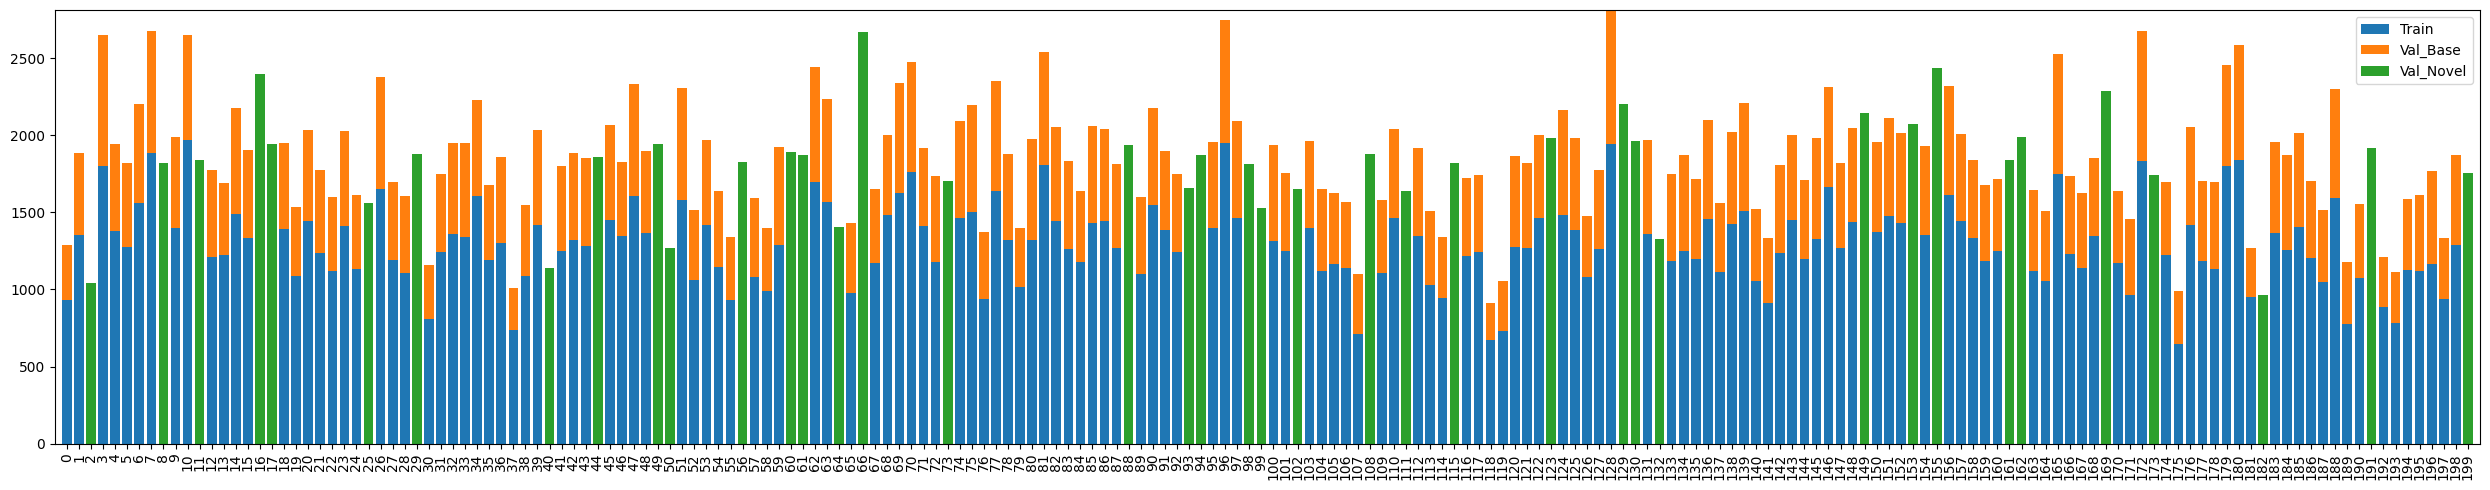

In [33]:
import pandas as pd
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

def load_labels(file_paths):
    """Charge les labels de plusieurs fichiers et retourne une DataFrame."""
    labels = []
    for file_path in tqdm(file_paths):
        with open(file_path) as f:
            for line in f:
                labels.append(line.split(" ")[0])
    return pd.DataFrame({"support": labels})

def process_data(train_files, val_files, test_files):
    """Traite les fichiers et retourne un DataFrame combiné."""
    # Charger les données
    aa = load_labels(train_files).astype(int)
    bb = load_labels(val_files).astype(int)
    cc = load_labels(test_files).astype(int)

    # Comptage des valeurs
    counta = aa["support"].value_counts()
    countb = bb["support"].value_counts()
    countc = cc["support"].value_counts()

    # Fusionner les classes uniques
    classes = pd.concat([counta, countb, countc]).index.unique()
    classes = pd.to_numeric(classes).sort_values()

    return classes, counta, countb, countc

def plot_data(classes, counta, countb, countc):
    """Trace les graphiques de type barres empilées."""
    # Initialisation des dictionnaires avec 0 pour chaque classe
    listea = {cls: counta.get(cls, 0) for cls in classes}
    listeb = {cls: countb.get(cls, 0) for cls in classes}
    listec = {cls: countc.get(cls, 0) for cls in classes}

    # Créer un DataFrame pour les données de barres empilées
    df = pd.DataFrame({'Train': listea, 'Val': listeb, 'Test': listec}, index=classes)
    df = df.sort_index(ascending=True)

    position = range(len(df.index))

    # Créer le graphique
    fig, ax = plt.subplots(figsize=(25,5))
    ax.bar(position, df['Train'], label='Train')
    ax.bar(position, df['Val'], bottom=df['Train'], label='Val_Base')
    ax.bar(position, df['Test'], bottom=df['Train'] + df['Val'], label='Val_Novel')

    # Ajouter les éléments au graphique
    ax.legend()
    ax.set_xticks(position)  # Définir seulement les positions de l'index existant
    ax.set_xticklabels(df.index, rotation=90)
    ax.set_xlim(min(position) - 1, max(position) + 1)
    plt.tight_layout()
    plt.show()

#plt.style.use("dark_background")

# Main
a = 'labels'
train_files = glob.glob(f'{a}/train/*.txt')
val_files = glob.glob(f'{a}/valid/*.txt')
test_files = glob.glob(f'{a}/test/*.txt')

classes, counta, countb, countc = process_data(train_files, val_files, test_files)
print(classes)
print(len(classes))
plot_data(classes, counta, countb, countc)